# **Data preprocessing**

In [1]:
import numpy as np
import pandas as pd
import matplotlib #
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn #
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve,confusion_matrix
from sklearn.model_selection import KFold

In [2]:
print("numpy: {}".format(np.__version__))
print("pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("sklearn: {}".format(sklearn.__version__))

numpy: 1.19.5
pandas: 1.1.5
matplotlib: 3.2.2
seaborn: 0.11.2
sklearn: 1.0.1


In [3]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [4]:
data_path = "creditcard.csv"
df = pd.read_csv(data_path)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


* Create data frames for the normal points and for the fraudulent points.

In [7]:
normal = df[df.Class == 0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class == 1]

* Add some code to check the shapes.

In [8]:
print(f"Normal: {normal.shape}")
print(f"Anomaly: {anomaly.shape}")

Normal: (142158, 31)
Anomaly: (492, 31)


* Split up normal points and anomalies into training and testing sets.

In [10]:
normal_train, normal_test = train_test_split(normal, test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)

* Create your training and validation splits.

In [11]:
normal_train, normal_validate = train_test_split(normal_train, test_size = 0.25, random_state = 2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size = 0.25, random_state = 2020)

* Create your final training, testing, and validation sets.
* Concatenate the respective normal and anomaly data splits.
* Define x_train, x_test, and x_validate.

In [12]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

* Define y_train, y_test, and y_validate.

In [13]:
y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

* Drop the column Class in the x sets.

In [14]:
x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

* Get the shapes of the sets.

In [15]:
print("Training sets:\nx_train: {} y_train: {}".format(x_train.shape, y_train.shape))
print("\nTesting sets:\nx_test: {} y_test: {}".format(x_test.shape, y_test.shape))
print("\nValidation sets:\nx_validate: {} y_validate: {}".format(x_validate.shape, y_validate.shape))

Training sets:
x_train: (85588, 30) y_train: (85588,)

Testing sets:
x_test: (28531, 30) y_test: (28531,)

Validation sets:
x_validate: (28531, 30) y_validate: (28531,)


* Scale everything down by normalizing the data.
* Normalizes all of the data such that the mean is 0 and the standard deviation is 1.

In [16]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

# **Model Training**

*  Define the logistic regression model.

In [17]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver='newton-cg').fit(x_train, y_train)

# **Model Evaluation**

* Find the accuracy using the built-in score function of the model.

In [18]:
eval_acc = sk_model.score(x_test, y_test)

* Get the predictions and calculate the AUC score.

In [19]:
preds = sk_model.predict(x_test)
auc_score = roc_auc_score(y_test, preds)

* Print out the scores.

In [20]:
print(f"Auc Score: {auc_score:.3%}")
print(f"Eval Accuracy: {eval_acc:.3%}")

Auc Score: 84.331%
Eval Accuracy: 99.867%


* Generate the ROC curve for the trained logistic regression model.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


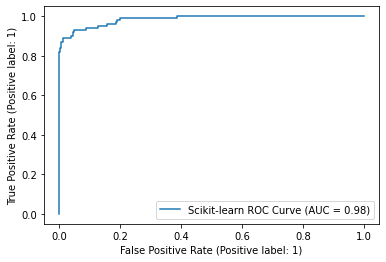

In [21]:
roc_plot = plot_roc_curve(sk_model, x_test, y_test, name='Scikit-learn ROC Curve')

* Build the confusion matrix and plot it using seaborn.

Text(0.5, 15.0, 'Predicted')

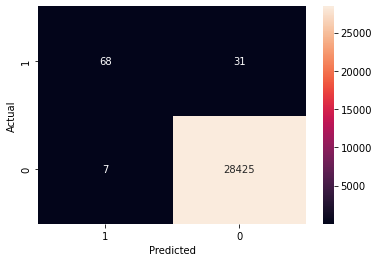

In [22]:
conf_matrix = confusion_matrix(y_test, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

# **Model Validation**

* Define a list of weights to iterate over.

In [23]:
anomaly_weights = [1, 5, 10, 15]

* Define the number of folds and initialize data fold generator.

In [24]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

* Define the validation script.

In [25]:
logs = []
for f in range(len(anomaly_weights)):
  fold = 1
  accuracies = []
  auc_scores= []
  for train, test in kfold.split(x_validate, y_validate):
    weight = anomaly_weights[f]
    class_weights= {
        0:1,
        1: weight
    }
    sk_model = LogisticRegression(random_state=None,
                                  max_iter=400,
                                  solver='newton-cg',
                                  class_weight=class_weights).fit(x_validate[train],
                                                                  y_validate[train])
    for h in range(40): print('-', end="")
    print(f"\nfold {fold}\nAnomaly Weight: {weight}")
    eval_acc = sk_model.score(x_validate[test], y_validate[test])
    preds = sk_model.predict(x_validate[test])
    try:
      auc_score = roc_auc_score(y_validate[test], preds)
    except:
      auc_score = -1
    print("AUC: {}\neval_acc: {}".format(auc_score, eval_acc))
    accuracies.append(eval_acc)
    auc_scores.append(auc_score)
    log = [sk_model, x_validate[test], y_validate[test], preds]
    logs.append(log)
    fold = fold + 1
print("\nAverages: ")
print("Accuracy: ", np.mean(accuracies))
print("AUC: ", np.mean(auc_scores))
print("Best: ")
print("Accuracy: ", np.max(accuracies))
print("AUC: ", np.max(auc_scores))

----------------------------------------
fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------
fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------
fold 3
Anomaly Weight: 1
AUC: 0.8179179195189047
eval_acc: 0.9980722046968104
----------------------------------------
fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------
fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693
----------------------------------------
fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------
fold 2
Anomaly Weight: 5
AUC: 0.9515893956527202
eval_acc: 0.9980722046968104
----------------------------------------
fold 3
Anomaly Weight: 5
AUC: 0.9314663169342972
eval_acc: 0.9987732211706976
----------------------------------------
fold 4
Anomaly Weight: 

* Begin the first fold with weight ten, so the second fold is at index 11.

In [26]:
sk_model, x_val, y_val, preds = logs[11]

* Look at the ROC curve.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


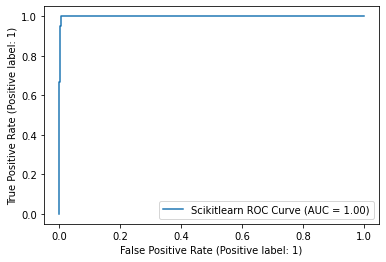

In [27]:
roc_plot = plot_roc_curve(sk_model, x_val, y_val, name='Scikitlearn ROC Curve')

* Look at the confusion matrix to get a better idea of how the model performed on this fold.

Text(0.5, 15.0, 'Predicted')

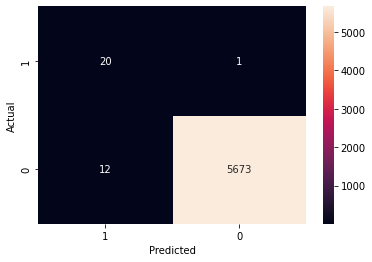

In [28]:
conf_matrix = confusion_matrix(y_val, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')